In [1]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

sample_sentence_1='I am happy.'
ss_1 = sid.polarity_scores(sample_sentence_1)
print('sentiment score for sentence 1',ss_1)

sample_sentence_2='I am sad.'
ss_2 = sid.polarity_scores(sample_sentence_2)
print('sentiment score for sentence 2',ss_2)

sample_sentence_3='I am going to New Delhi tommorow.'
ss_3 = sid.polarity_scores(sample_sentence_3)
print('sentiment score for sentence 3',ss_3)


sentiment score for sentence 1 {'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}
sentiment score for sentence 2 {'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'compound': -0.4767}
sentiment score for sentence 3 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [2]:
import pandas as pd
import numpy as np
data = pd.read_csv('preprocessed_data.csv',nrows=35000)

In [3]:
data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [4]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import nltk
# nltk.download('vader_lexicon')
Neg = []
Pos = []
Nue = []
Comp = []

sia = SentimentIntensityAnalyzer()
for essay in data['essay'].values:
    k = sia.polarity_scores(essay)
    Neg.append(k['neg'])
    Nue.append(k['neu'])
    Pos.append(k['pos'])
    Comp.append(k['compound'])

data['Positive'] = Pos
data['Negetive'] = Neg
data['Nuetral'] = Nue
data['Compound'] = Comp

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [5]:
y = data['project_is_approved'].values
x = data.drop(['project_is_approved'],axis=1)

# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
x.head(1)

(24500, 12) (24500,)
(10500, 12) (10500,)


,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price,Positive,Negetive,Nuetral,Compound
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.205,0.013,0.783,0.9867


In [6]:
def response_coding(x_train,y_train,feature):   
    classes = dict()
    unique_labels = x_train.loc[:,feature].unique()
    for label in unique_labels:
        total_points = x_train.loc[:,feature][x_train[feature] == label].count()
        class_0 = x_train.loc[:,feature][((x_train[feature] == label) & (y_train == 0))].count()
        class_1 = x_train.loc[:,feature][((x_train[feature] == label) & (y_train == 1))].count()
        classes[label] = [class_0/total_points,class_1/total_points]
    return classes    

<h2>1.3 Make Data Model Ready: encoding categorical features</h2>


In [7]:
cat_features = ['school_state','teacher_prefix','project_grade_category','clean_categories','clean_subcategories']
for feature in cat_features:
    res_map = response_coding(X_train,y_train,feature)
    #print(res_map)
    lst = X_train.loc[:,feature]
    fea_0 = []
    fea_1 = []
    for cat in lst:
        fea_0.append(res_map.get(cat)[0])
        fea_1.append(res_map.get(cat)[1])
    class1 = feature+'_1'
    class0 = feature+'_0'
    X_train.drop([feature],axis=1,inplace=True)
    X_train[class0] = fea_0
    X_train[class1] = fea_1

    lst = X_test.loc[:,feature]
    fea_0 = []
    fea_1 = []
    for cat in lst:
        fea_0.append(res_map.get(cat,[0.5,0.5])[0])
        fea_1.append(res_map.get(cat,[0.5,0.5])[1])
    class1 = feature+'_1'
    class0 = feature+'_0'
    X_test.drop([feature],axis=1,inplace=True)
    X_test[class0] = fea_0
    X_test[class1] = fea_1
    # print(X_train.head())

In [8]:
X_train.head(2)

,teacher_number_of_previously_posted_projects,essay,price,Positive,Negetive,Nuetral,Compound,school_state_0,school_state_1,teacher_prefix_0,teacher_prefix_1,project_grade_category_0,project_grade_category_1,clean_categories_0,clean_categories_1,clean_subcategories_0,clean_subcategories_1
10530,1,i seek integrate subjects much possible fifth ...,76.75,0.194,0.000,0.806,0.9735,0.128623,0.871377,0.157567,0.842433,0.147404,0.852596,0.141529,0.858471,0.181360,0.818640
33806,11,i love third graders our title 1 school new yo...,426.99,0.298,0.026,0.676,0.9925,0.139750,0.860250,0.157567,0.842433,0.147404,0.852596,0.175853,0.824147,0.175853,0.824147


In [9]:
X_test.head(2)

,teacher_number_of_previously_posted_projects,essay,price,Positive,Negetive,Nuetral,Compound,school_state_0,school_state_1,teacher_prefix_0,teacher_prefix_1,project_grade_category_0,project_grade_category_1,clean_categories_0,clean_categories_1,clean_subcategories_0,clean_subcategories_1
29373,1,as teacher i lucky enough classroom move every...,346.89,0.29,0.038,0.672,0.9944,0.201531,0.798469,0.153037,0.846963,0.147404,0.852596,0.136302,0.863698,0.143172,0.856828
24311,17,our students special us we unique diverse clas...,270.91,0.39,0.008,0.602,0.9985,0.149573,0.850427,0.147869,0.852131,0.153809,0.846191,0.141463,0.858537,0.120805,0.879195


In [10]:
X_train_resp_code = X_train.loc[:,"school_state_0":"clean_subcategories_1"]
X_train_resp_code = np.array(X_train_resp_code)
X_train_resp_code.shape

(24500, 10)

In [11]:
X_test_resp_code = X_test.loc[:,"school_state_0":"clean_subcategories_1"]
X_test_resp_code = np.array(X_test_resp_code)
X_test_resp_code.shape

(10500, 10)

<h2>1.4 Make Data Model Ready: encoding eassay, and project_title</h2>

In [12]:
# Apply TF-IDF vectorization on 'Preprocessed_Essay' 

# Encoding of Essay using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=200)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = vectorizer.transform(X_train['essay'].values)
X_test_tfidf = vectorizer.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)

After vectorizations
(24500, 1921) (24500,)
(10500, 1921) (10500,)


In [13]:
#please use below code to load glove vectors 
import pickle
from tqdm import tqdm
import os
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [14]:
# Apply TF-IDF W2V vectorization on 'Preprocessed_Essay' 
tfidf_model = TfidfVectorizer(min_df=100)
tfidf_model.fit(X_train['essay'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names_out(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names_out())

# Encoding of Essay using TF-IDF W2V
X_train_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in X_train['essay'].values: # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_train_tfidf_w2v.append(vector)

X_train_tfidf_w2v = np.array(X_train_tfidf_w2v)
print(X_train_tfidf_w2v.shape)

X_test_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in X_test['essay']: # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_test_tfidf_w2v.append(vector)

X_test_tfidf_w2v = np.array(X_test_tfidf_w2v)
print(X_test_tfidf_w2v.shape)

(24500, 300)
(10500, 300)


In [15]:
from sklearn.preprocessing import Normalizer
scaler = Normalizer()

numeric = ['price','teacher_number_of_previously_posted_projects','Positive','Nuetral','Negetive','Compound']

scaler.fit(X_train[numeric])

X_train_numeric = scaler.transform(X_train[numeric])
X_test_numeric = scaler.transform(X_test[numeric])
print(X_train_numeric.shape)
print(X_test_numeric.shape)

(24500, 6)
(10500, 6)


In [16]:
from scipy.sparse import hstack
X_train1 = hstack((X_train_tfidf,X_train_resp_code,X_train_numeric)).tocsr()

X_test1 = hstack((X_test_tfidf,X_test_resp_code,X_test_numeric)).tocsr()

print("Shape final repesentation in set 1:")
print(X_train1.shape,y_train.shape)
print(X_test1.shape,y_test.shape)

Shape final repesentation in set 1:
(24500, 1937) (24500,)
(10500, 1937) (10500,)


In [17]:
X_train2 = np.hstack((X_train_tfidf_w2v,X_train_resp_code,X_train_numeric))
X_test2 = np.hstack((X_test_tfidf_w2v,X_test_resp_code,X_test_numeric))

print("Shape final repesentation in set 2:")
print(X_train2.shape,y_train.shape)
print(X_test2.shape,y_test.shape)

Shape final repesentation in set 2:
(24500, 316) (24500,)
(10500, 316) (10500,)


In [18]:
X1 = ['TF-IDF']
X2 = ['TFIDF-W2V']

<h2>1.6 Appling Models on different kind of featurization as mentioned in the instructions</h2>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

gb = GradientBoostingClassifier()

param_grid = {'max_depth':[1, 3, 7 ,10],'min_samples_split':[10, 25, 75, 100]}
cv1 = GridSearchCV(estimator=gb,param_grid=param_grid,scoring='roc_auc',cv = 5,n_jobs=-1)
cv1.fit(X_train1,y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 7, 10],
                         'min_samples_split': [10, 25, 75, 100]},
             scoring='roc_auc')

In [20]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

gb = GradientBoostingClassifier()

param_grid = {'max_depth':[1, 3, 7 ,10],'min_samples_split':[10, 25, 75, 100]}
cv2 = GridSearchCV(estimator=gb,param_grid=param_grid,scoring='roc_auc',cv = 5,n_jobs=-1)
cv2.fit(X_train2,y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 7, 10],
                         'min_samples_split': [10, 25, 75, 100]},
             scoring='roc_auc')

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\gurus\AppData\Local\Temp\ipykernel_32328\1185005090.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  grid = df.pivot('max_depth','min_samples_split','mean_test_score')


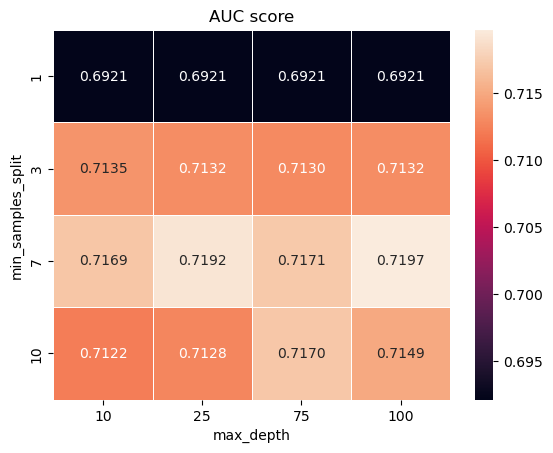

In [22]:
res = np.array(cv1.cv_results_['mean_test_score']).reshape(4,4)
grid = []
for i,depth in enumerate([1, 3, 7 ,10]):
    for j,samples_split in enumerate([10, 25, 75, 100]):
        grid.append([depth,samples_split,res[i][j]])

df = pd.DataFrame(grid,columns=['max_depth','min_samples_split','mean_test_score'])
grid = df.pivot('max_depth','min_samples_split','mean_test_score')
ax = sns.heatmap(grid,annot=True,fmt="0.4f",linewidths=0.5)

plt.xlabel("max_depth")
plt.ylabel("min_samples_split")
plt.title("AUC score")
plt.show()

C:\Users\gurus\AppData\Local\Temp\ipykernel_32328\1355953727.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  grid = df.pivot('max_depth','min_samples_split','mean_test_score')


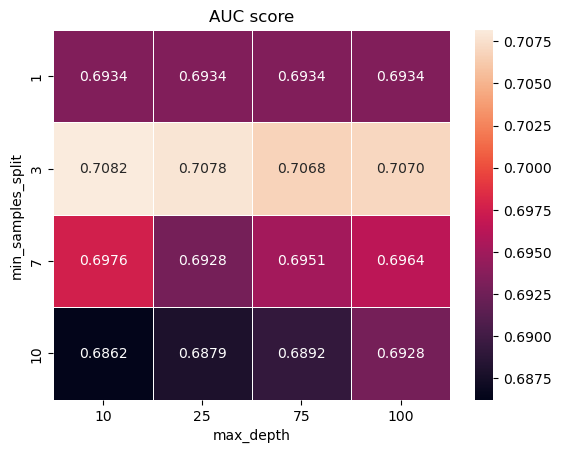

In [23]:
res = np.array(cv2.cv_results_['mean_test_score']).reshape(4,4)
grid = []
for i,depth in enumerate([1, 3, 7 ,10]):
    for j,samples_split in enumerate([10, 25, 75, 100]):
        grid.append([depth,samples_split,res[i][j]])

df = pd.DataFrame(grid,columns=['max_depth','min_samples_split','mean_test_score'])
grid = df.pivot('max_depth','min_samples_split','mean_test_score')
ax = sns.heatmap(grid,annot=True,fmt="0.4f",linewidths=0.5)

plt.xlabel("max_depth")
plt.ylabel("min_samples_split")
plt.title("AUC score")
plt.show()

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

In [25]:
X1.append(cv1.best_params_['max_depth'])
X1.append(cv1.best_params_['min_samples_split'])

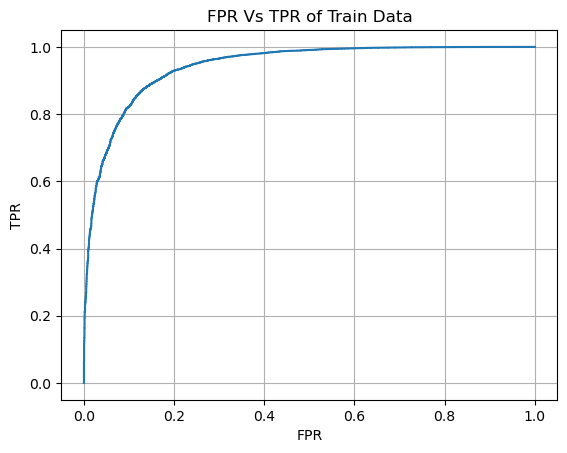

0.9429264231416319


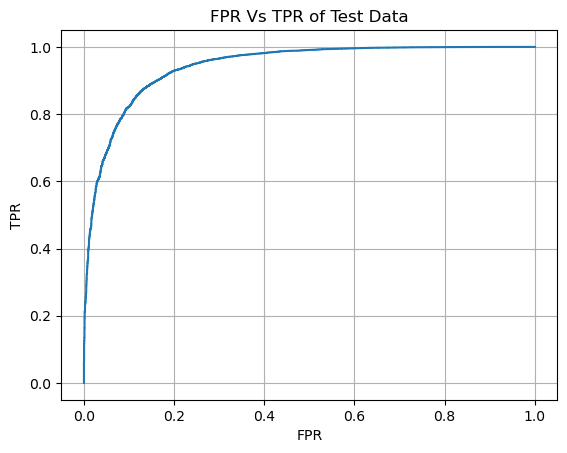

0.7037362102806117


In [26]:
gb = GradientBoostingClassifier(max_depth=cv1.best_params_['max_depth'],min_samples_split=cv1.best_params_['min_samples_split'])
gb.fit(X_train1,y_train)
pro_score_train = gb.predict_proba(X_train1)[:,1]
pro_score_test = gb.predict_proba(X_test1)[:,1]

# Plot the ROC-AUC curves using the probability predictions made on train and test data.
k_train = roc_curve(y_train,pro_score_train)
plt.plot(k_train[0], k_train[1])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("FPR Vs TPR of Train Data")
plt.grid()
plt.show()
print(auc(k_train[0],k_train[1]))


k_test = roc_curve(y_test,pro_score_test)
plt.plot(k_train[0], k_train[1])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("FPR Vs TPR of Test Data")
plt.grid()
plt.show()
print(auc(k_test[0],k_test[1]))

In [27]:
X1.append(auc(k_test[0],k_test[1]))

the maximum value of tpr*(1-fpr) 0.7598746127331295 for threshold 0.815 



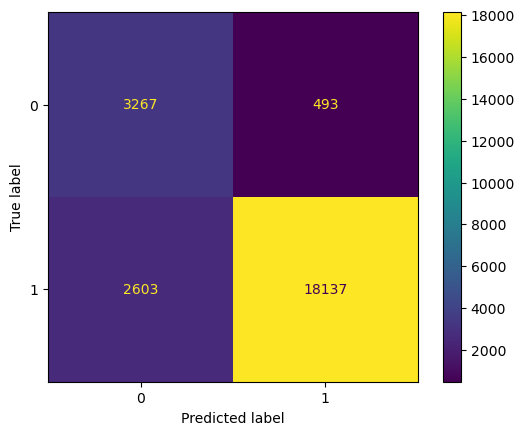

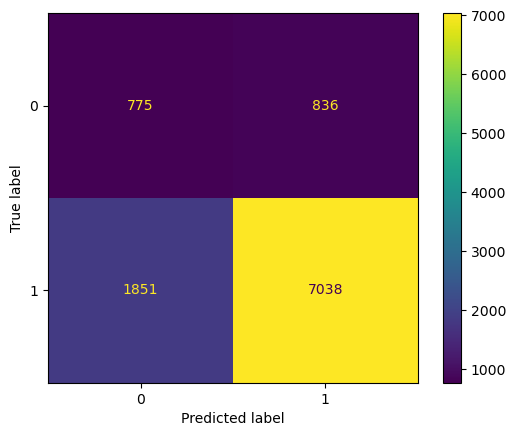

In [28]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)
best_thr_index = np.argmax((k_train[1]*(1-k_train[0])))
threshold = k_train[2][best_thr_index]
print("="*100)
# (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
print("the maximum value of tpr*(1-fpr)", max((k_train[1]*(1-k_train[0]))), "for threshold", np.round(threshold,3),"\n")

# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.

y_pred = []
FP_indices = [] #Indices of train datapoints which are False Positive
for i,prob in enumerate(pro_score_train):
    if prob > threshold:
        y_pred.append(1)
        if y_train[i] == 0:
            FP_indices.append(i)
    else:
        y_pred.append(0)

ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred)).plot()

y_pred = []
for prob in pro_score_test:
    if prob > threshold:
        y_pred.append(1)
    else:
        y_pred.append(0)


ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

In [29]:
X2.append(cv2.best_params_['max_depth'])
X2.append(cv2.best_params_['min_samples_split'])

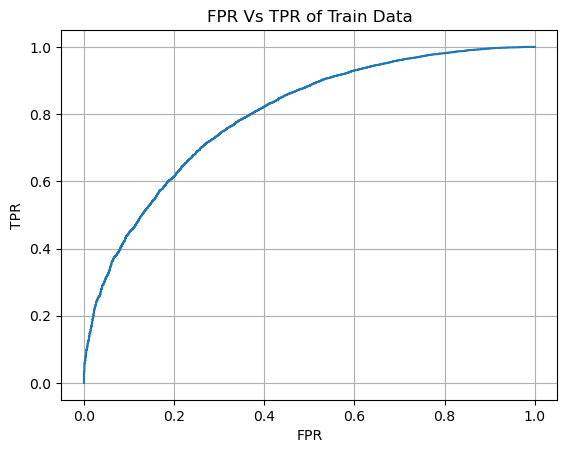

0.7969633596811588


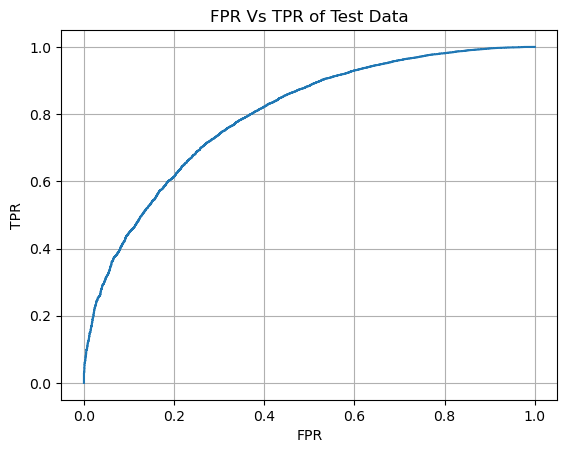

0.6953956720792387


In [30]:
gb = GradientBoostingClassifier(max_depth=cv2.best_params_['max_depth'],min_samples_split=cv2.best_params_['min_samples_split'])
gb.fit(X_train2,y_train)
pro_score_train = gb.predict_proba(X_train2)[:,1]
pro_score_test = gb.predict_proba(X_test2)[:,1]

# Plot the ROC-AUC curves using the probability predictions made on train and test data.
k_train = roc_curve(y_train,pro_score_train)
plt.plot(k_train[0], k_train[1])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("FPR Vs TPR of Train Data")
plt.grid()
plt.show()
print(auc(k_train[0],k_train[1]))


k_test = roc_curve(y_test,pro_score_test)
plt.plot(k_train[0], k_train[1])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("FPR Vs TPR of Test Data")
plt.grid()
plt.show()
print(auc(k_test[0],k_test[1]))

In [31]:
X2.append(auc(k_test[0],k_test[1]))

the maximum value of tpr*(1-fpr) 0.5204983432159052 for threshold 0.837 



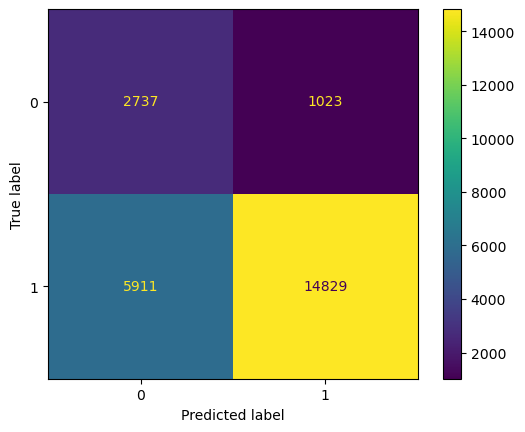

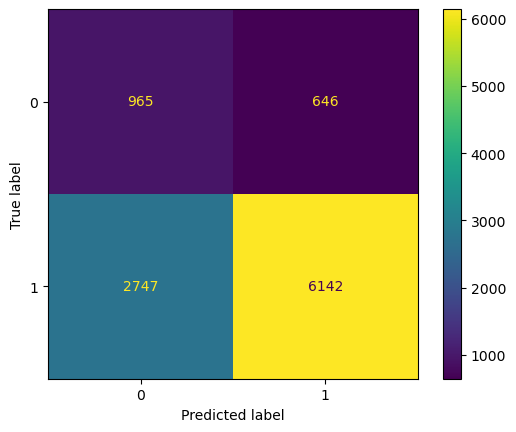

In [32]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)
best_thr_index = np.argmax((k_train[1]*(1-k_train[0])))
threshold = k_train[2][best_thr_index]
print("="*100)
# (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
print("the maximum value of tpr*(1-fpr)", max((k_train[1]*(1-k_train[0]))), "for threshold", np.round(threshold,3),"\n")

# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.

y_pred = []
FP_indices = [] #Indices of train datapoints which are False Positive
for i,prob in enumerate(pro_score_train):
    if prob > threshold:
        y_pred.append(1)
        if y_train[i] == 0:
            FP_indices.append(i)
    else:
        y_pred.append(0)

ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred)).plot()

y_pred = []
for prob in pro_score_test:
    if prob > threshold:
        y_pred.append(1)
    else:
        y_pred.append(0)


ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

<h1>3. Summary</h1>

<br> as mentioned in the step 4 of instructions

In [38]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ['Model',"max_depth","min_samples_split",'Test ROC-AUC']
x.add_row(X1)
x.add_row(X2)

In [39]:
x

Model,max_depth,min_samples_split,Test ROC-AUC
TF-IDF,7,100,0.7037362102806117
TFIDF-W2V,3,10,0.6953956720792387
